# CDC Ensemble Challenge

## Challenge model output requirements

Values in the target column must be a character (string) and be one of the following specific targets:
- "N wk ahead cum **death**” where N is a number between 1 and 20
- “N wk ahead inc **death**” where N is a number between 1 and 20
- “N wk ahead inc **case**” where N is a number between 1 and 8
- “N day ahead inc **hosp**” where N is a number between 0 and 130

## Work plan to prepare models meeting these requirements
1. Teams agree on **in-context input data and readouts** for modeling. This allows models to be structurally prepared for integration.
2. TA2 **selects models** and adds any necessary **extensions** for data mapping and readout.
3. TA2 passes these structurally prepared models to TA3 with **original published parameterization**. Prior parameter **distributions** can come from TA1/2
4. TA3 takes model and runs any **parameter estimation** necessary with in-context data.
5. TA3 creates ensemble of models to produce **predictions**.

## Preparing existing models for the ensemble challenge

In [1]:
import copy
import os
import re
import glob
import pandas as pd
import tqdm
from collections import defaultdict
import pystow
from sympy import Symbol
from mira.sources.sbml import template_model_from_sbml_file
from mira.metamodel import Concept, NaturalConversion, Parameter, Observable, Distribution, model_to_json_file
from mira.metamodel.search import find_models_with_grounding
from mira.metamodel.comparison import get_dkg_refinement_closure
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.metamodel.ops import simplify_rate_laws

### Explore BioModels and find relevant models

### Step 1: process all BioModels for COVID-19

In [2]:
base_folder = pystow.join('mira', 'biomodels', 'models')
fnames = sorted(glob.glob(os.path.join(base_folder.as_posix(),
                                       'BIOMD*/BIOMD*.xml')))
models = {}
for fname in tqdm.tqdm(fnames):
    model_id = os.path.splitext(os.path.basename(fname))[0]
    models[model_id] = template_model_from_sbml_file(fname)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.24it/s]


### Step 2: Look for a set of domain concepts of interest

These concepts are from the MIRA Epidemiology Domain Knowledge Graph.

In [3]:
groundings = {
    'hospitalization': 'ncit:C25179',
    'death': 'ncit:C28554',
    'detected': 'ncit:C15220',
    'infected': 'ido:0000511',
}

MIRA's `mira.metamodel.search.find_models_with_grounding` function can be used to discover models with given domain concepts.

We organize the results of the search into a table.

In [4]:
models_for_grounding = defaultdict(set)
for grounding, curie in groundings.items():
    db, id = curie.split(':')
    models_for_grounding[grounding] = set(find_models_with_grounding(models, db, id))
models_for_grounding = dict(models_for_grounding)

In [5]:
# Create a DataFrame with one row for each model file and one column for each term
df = pd.DataFrame(index=sorted(set(models)), columns=models_for_grounding.keys())

# Fill the DataFrame with boolean values indicating whether each model file is associated with each term
for term, models_ in models_for_grounding.items():
    for model in models_:
        df.loc[model, term] = True

df.fillna(False, inplace=True)  # Fill missing values with False

# Reset the index to make the model file paths a regular column
df = df.reset_index().rename(columns={'index': 'model'})

In [6]:
df

,model,hospitalization,death,detected,infected
0,BIOMD0000000249,False,False,False,False
1,BIOMD0000000294,False,False,False,False
2,BIOMD0000000715,False,False,False,True
3,BIOMD0000000716,False,False,False,True
4,BIOMD0000000717,False,False,False,True
5,BIOMD0000000726,False,False,False,True
6,BIOMD0000000949,False,False,False,False
7,BIOMD0000000950,False,False,False,False
8,BIOMD0000000955,False,True,True,True
9,BIOMD0000000956,False,False,False,True


### Step 3: Prepare to add some extra information to models

Here we define reused functions to:
1. Define **parameter distributions** for each model. Note that these are just **placeholders** for now to demonstrate the use of distributions. The distributions are defined around the original parameter values.
2. Define **observable domain concepts** corresponding to the challenge readouts. These will be integrated into models.

In [7]:
from mira.modeling.viz import *

In [8]:
def add_distribution(p):
    if p.value == 0:
        return
    else:
        p.distribution = Distribution(
            type='StandardUniform1',
            parameters={
                'minimum': p.value-0.2*abs(p.value),
                'maximum': p.value+0.2*abs(p.value),
            }
        )

We create domain concepts corresponding to the challenge varibles to predict:

In [9]:
cases = Concept(name='Cases',
                identifiers={'ido': '0000511'},
                context={'diagnosed': 'ncit:C113725'})
hospitalizations = Concept(name='Hospitalizations',
                           identifiers={'ido': '0000511'},
                           context={'hospitalization': 'ncit:C25179'})
deaths = Concept(name='Deaths',
                 identifiers={'ncit': 'C28554'})

### Model 1: Zong et al. model

In [10]:
model = copy.deepcopy(models['BIOMD0000000983'])

#### Rate law interpretation and manipulation -> structural simplification

In [11]:
for template in model.templates[2:4]:
    print(template.type, template.rate_law.args[0])

GroupedControlledConversion Susceptible_unconfined*beta*(1.0 - sigma)*(Infected_reported*n + Infected_unreported)
GroupedControlledConversion Susceptible_unconfined*beta*sigma*(Infected_reported*n + Infected_unreported)


In [12]:
model = simplify_rate_laws(model)

In [13]:
for template in model.templates[2:6]:
    print(template.type, template.rate_law.args[0])

ControlledConversion Infected_reported*Susceptible_unconfined*beta*n*(1.0 - sigma)
ControlledConversion Infected_unreported*Susceptible_unconfined*beta*(1.0 - sigma)
ControlledConversion Infected_reported*Susceptible_unconfined*beta*n*sigma
ControlledConversion Infected_unreported*Susceptible_unconfined*beta*sigma


In [14]:
model.templates = model.templates[2:]

#### Stting up observables

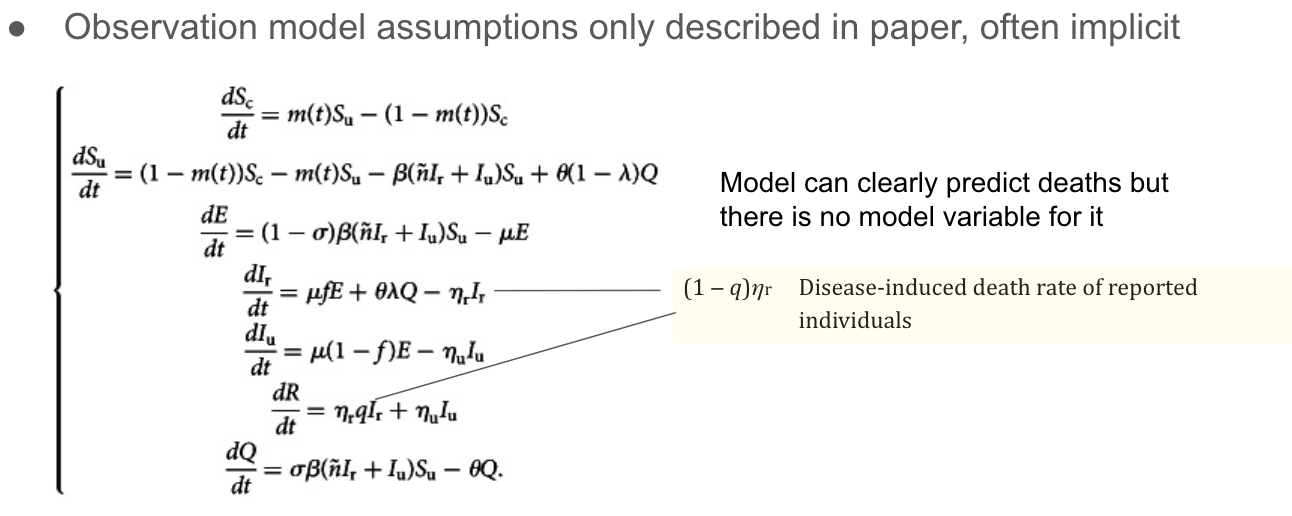

First we implement deaths in the model

In [15]:
deceased = Concept(name='Deceased', identifiers={'ncit': 'C28554'})
t = NaturalConversion(
        subject=model.get_concept('Infected_reported'),
        outcome=deceased,
        rate_law=(1-Symbol('q'))*Symbol('eta_r')*Symbol('Infected_reported'),
    )

In [16]:
model = model.add_template(t)

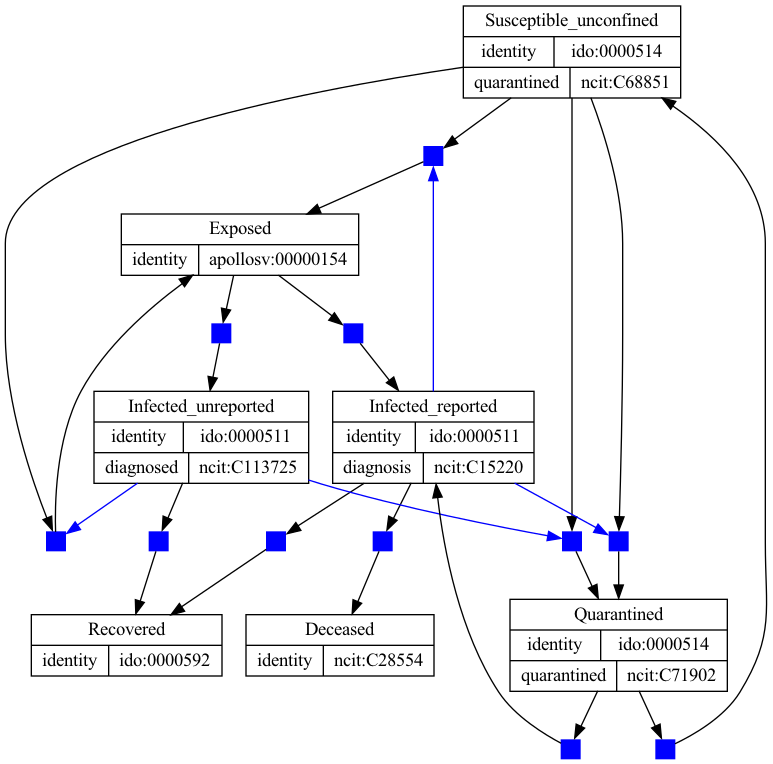

In [17]:
GraphicalModel.for_jupyter(model, width='50%')

Next we add a parameter for observing hospitalization

In [18]:
model.parameters['h'] = Parameter(name='h', value=0.05)

In [19]:
model.observables = {
    'Cases': Observable(**cases.dict(), expression=Symbol('Infected_reported')),
    'Hospitalizations': Observable(**hospitalizations.dict(), expression=Symbol('h')*Symbol('Infected_reported')),
    'Deaths': Observable(**deaths.dict(), expression=Symbol('Deceased'))
}

In [20]:
param_reduce = ['m_t_phase_1', 'm_t_phase_2', 'm_t_phase_3', 'tau_1', 'tau_2', 'tau_3', 'tau_f', 'm_t',
                'a', 'b', 'p']

In [21]:
for p in param_reduce:
    model.eliminate_parameter(p)
for v in model.parameters.values():
    add_distribution(v)

Now export the template model and the Petri net model

In [22]:
model_to_json_file(model, 'BIOMD0000000983_template_model.json')

In [23]:
pm = PetriNetModel(Model(model))
pm.to_json_file('BIOMD0000000983_miranet.json', indent=1)

NameError: name 'PetriNetModel' is not defined

### Model 2: Giordano et al (SIDARTHE) model

In [24]:
model = copy.deepcopy(models['BIOMD0000000955'])
model = simplify_rate_laws(model)

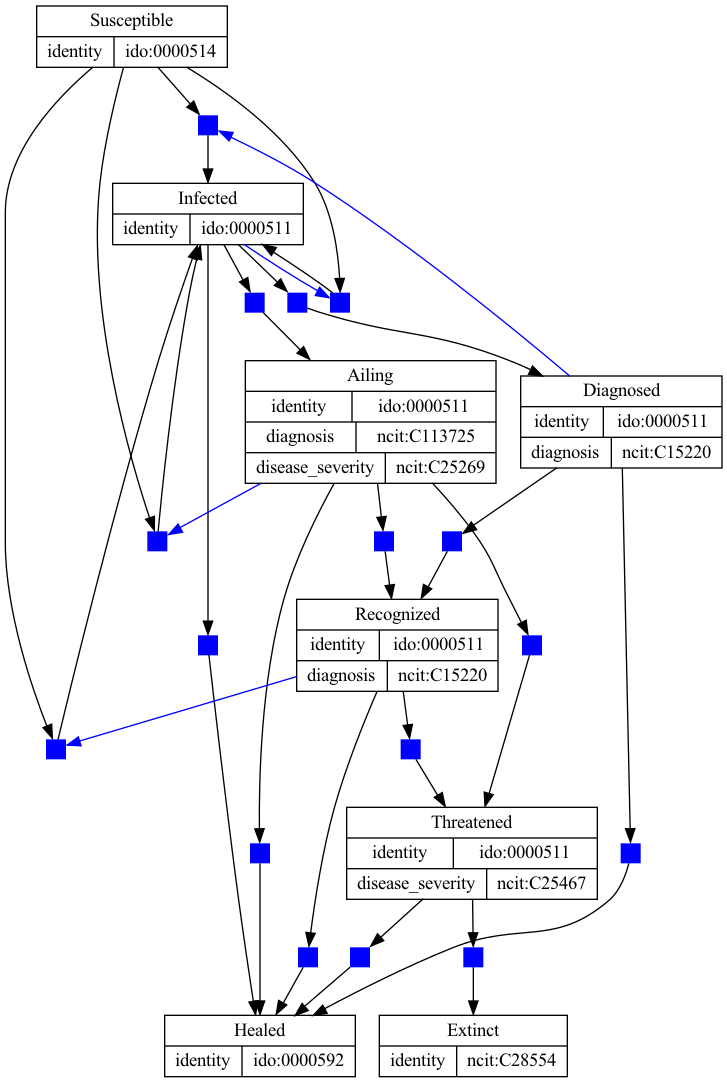

In [25]:
GraphicalModel.for_jupyter(model, width='50%')

In [26]:
param_reduce = ['Event_trigger_Fig3b', 'Event_trigger_Fig3d', 'Event_trigger_Fig4b', 'Event_trigger_Fig4d',
                'ModelValue_16', 'ModelValue_17', 'ModelValue_18', 'ModelValue_19', 'ModelValue_20', 'ModelValue_21',
                'Italy']

In [27]:
for p in param_reduce:
    model.substitute_parameter(p)
for v in model.parameters.values():
    add_distribution(v)

In [32]:
from mira.metamodel import Unit, Time
import sympy

In [34]:
for template in model.templates:
    for concept in template.get_concepts():
        concept.units = Unit(expression=sympy.parse_expr('1'))
model.time = Time(name='t', units=Unit(expression=sympy.parse_expr('day')))

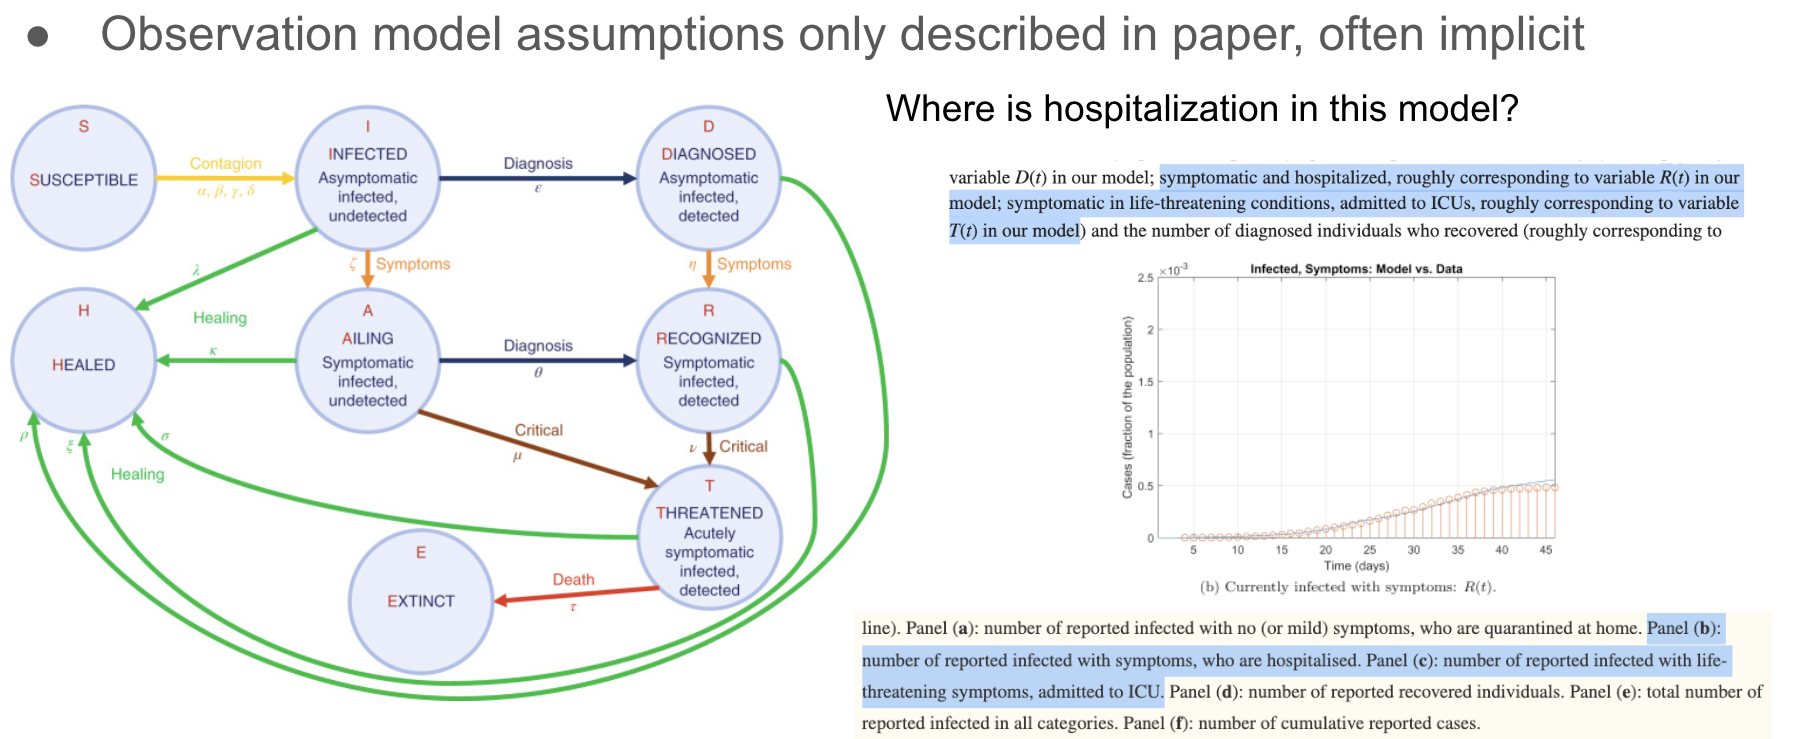

In [35]:
model.observables = {
    'Cases': Observable(**cases.dict(), expression=Symbol('Diagnosed')+Symbol('Recognized')+Symbol('Threatened')),
    'Hospitalizations': Observable(**hospitalizations.dict(), expression=Symbol('Recognized')+Symbol('Threatened')),
    'Deaths': Observable(**deaths.dict(), expression=Symbol('Extinct'))
}

In [36]:
model_to_json_file(model, 'BIOMD0000000955_template_model.json')
pm = AskeNetPetriNetModel(Model(model))
pm.to_json_file('BIOMD0000000955_askenet.json', indent=1)

### Model 3: Paiva et al model

In [30]:
model = copy.deepcopy(models['BIOMD0000000960'])
model = simplify_rate_laws(model)

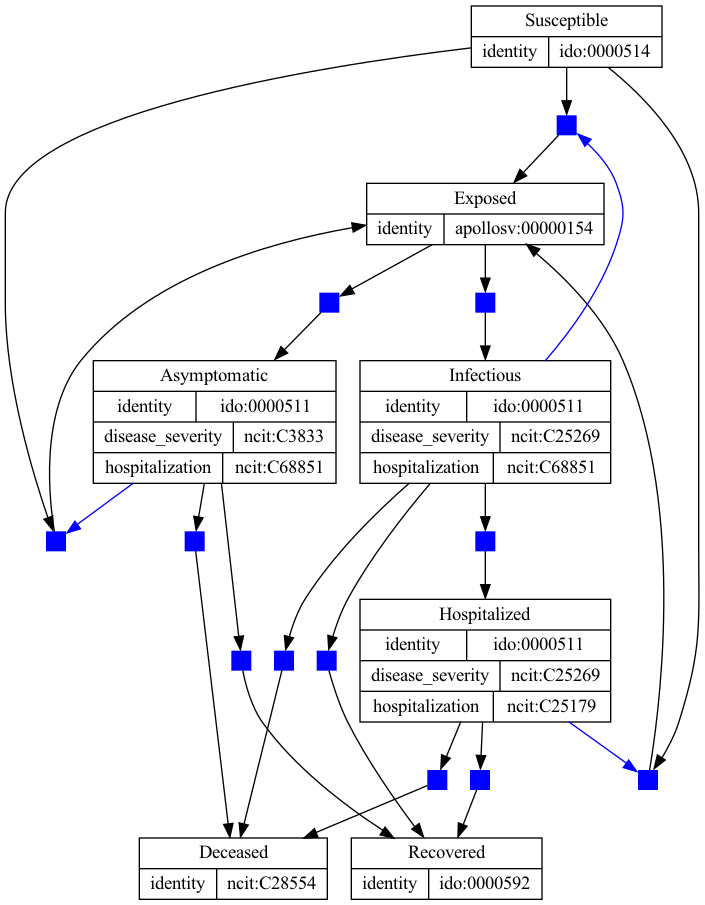

In [31]:
GraphicalModel.for_jupyter(model, width='50%')

### Parameter simplification
- Eliminate non-US parameters
- Eliminate duplicate parameters (initials defined for static parameters)
- Enable US-specific scenario parameter
- Eliminate all unused parameters

In [32]:
param_reduce = [p for p, v in model.parameters.items()
                if any(c in v.description for c in {'China', 'Italy', 'Spain', 'France', 'Germany'})]
for p in param_reduce:
    model.eliminate_parameter(p)

In [33]:
redundant_params = []
for p in model.parameters.values():
    match = re.match(r'^Initial for (.*)$', p.description)
    if match:
        other_param = match.groups()[0]
        if other_param in model.parameters:
            redundant_params.append((p.name, other_param))
        elif '_' + other_param in model.parameters:
            redundant_params.append((p.name, '_' + other_param))

In [34]:
for redundant_param, preserved_param in redundant_params:
    model.eliminate_duplicate_parameter(redundant_param, preserved_param)

In [35]:
model.substitute_parameter('_6_Trigger_USA', 1)

In [36]:
model.eliminate_unused_parameters()

In [37]:
for v in model.parameters.values():
    add_distribution(v)

#### Set up observables

In [38]:
model.observables = {
    'Cases': Observable(**cases.dict(), expression=Symbol('Infectious')),
    'Hospitalizations': Observable(**hospitalizations.dict(), expression=Symbol('Hospitalized')),
    'Deaths': Observable(**deaths.dict(), expression=Symbol('Deceased'))
}

#### Save model

In [39]:
model_to_json_file(model, 'BIOMD0000000960_template_model.json')
pm = PetriNetModel(Model(model))
pm.to_json_file('BIOMD0000000960_miranet.json', indent=1)